## Does temperature predict electricity consumption?
Ivan Peynirdzhiev  

data folder: https://drive.google.com/drive/folders/1Zd3Q9BxGdvliB0Q2TPjPyQ9v6qizl-Rg?usp=sharing

I wanted to research whether air temperature is having an effect on electricity consumption. The reason behind such relationship is that some electricity is needed for heating, the demand for which rises with falling temperatures. 

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mpl_toolkits.basemap import Basemap

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

### 1.  Choosing weather stations.
I wanted to explore this relationship for Bulgaria, but as I didn’t manage to find the required data from NIMH. As temperature varies during the day, an hourly data would be appropriate. There is hourly temperature data for Germany at dwd.de, so I decided to use this data.

In [3]:
stations = pd.read_csv('data/TU_Stundenwerte_Beschreibung_Stationen.txt', sep = '\s+')

First, I wanted to see where the weather stations are. This is a file with all the weather stations of the DWD, with coordinates.

In [4]:
stations.head()

,Stations_id,von_datum,bis_datum,Stationshoehe,geoBreite,geoLaenge,Stationsname,Bundesland
0,3,19500401,20110331,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
1,44,20070401,20220829,44,52.9336,8.2370,Gro�enkneten,Niedersachsen
2,52,19760101,19880101,46,53.6623,10.1990,Ahrensburg-Wulfsdorf,Schleswig-Holstein
3,71,20091201,20191231,759,48.2156,8.9784,Albstadt-Badkap,Baden-W�rttemberg
4,73,20070401,20220829,340,48.6159,13.0506,Aldersbach-Kriestorf,Bayern


In order to read the file I had to manually remove whitespaces between station names, because there was the columns were separated with whitespaces as well.

In [5]:
stations.dtypes

Stations_id        int64
von_datum          int64
bis_datum          int64
Stationshoehe      int64
geoBreite        float64
geoLaenge        float64
Stationsname      object
Bundesland        object
dtype: object

As all the data type is ‘object’ I convert the coordinate columns to ‘float’ and station id to ‘int’. 

In [6]:
stations[['geoBreite', 'geoLaenge']].astype('float')
stations.Stations_id.astype('int32')

0          3
1         44
2         52
3         71
4         73
       ...  
660    15444
661    15555
662    15813
663    19171
664    19172
Name: Stations_id, Length: 665, dtype: int32

In [7]:
stations.dtypes

Stations_id        int64
von_datum          int64
bis_datum          int64
Stationshoehe      int64
geoBreite        float64
geoLaenge        float64
Stationsname      object
Bundesland        object
dtype: object

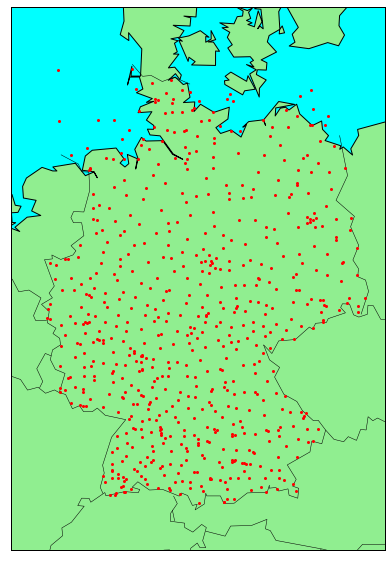

In [8]:
plt.figure(figsize = (12, 10))
m = Basemap(projection = "merc", llcrnrlat = 46.5, llcrnrlon = 5, urcrnrlat = 56, urcrnrlon = 15.5, resolution = 'l')
x, y = m(stations.geoLaenge.tolist(), stations.geoBreite.tolist())

m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color = "lightgreen", lake_color = "aqua")
m.drawmapboundary(fill_color = "aqua")

m.plot(x, y, "o", markersize = 2, color = "red")
plt.show()

Now I choose four stations in different parts of Germany. After looking at a climate map of Germany, these four point represent the two main types of climate temperate and continental.

In [9]:
stations[stations.Stations_id == 44]

,Stations_id,von_datum,bis_datum,Stationshoehe,geoBreite,geoLaenge,Stationsname,Bundesland
1,44,20070401,20220829,44,52.9336,8.237,Gro�enkneten,Niedersachsen


In [10]:
stations[stations.Stations_id == 303]

,Stations_id,von_datum,bis_datum,Stationshoehe,geoBreite,geoLaenge,Stationsname,Bundesland
34,303,19930819,20220823,54,52.0613,13.4997,Baruth,Brandenburg


In [11]:
stations[stations.Stations_id == 1161]

,Stations_id,von_datum,bis_datum,Stationshoehe,geoBreite,geoLaenge,Stationsname,Bundesland
117,1161,20050201,20220829,384,48.8777,11.2349,Eichst�tt-Landershofen,Bayern


In [12]:
stations[stations.Stations_id == 603]

,Stations_id,von_datum,bis_datum,Stationshoehe,geoBreite,geoLaenge,Stationsname,Bundesland
69,603,20010403,20220829,147,50.7293,7.204,K�nigswinter-Heiderhof,Nordrhein-Westfalen


In [13]:
chosen_stations_index = [1,34,117,69]

In [14]:
chosen_stations = stations.iloc[chosen_stations_index]

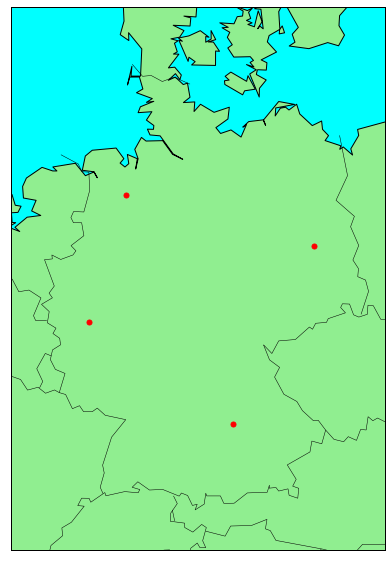

In [15]:
plt.figure(figsize = (12, 10))
m = Basemap(projection = "merc", llcrnrlat = 46.5, llcrnrlon = 5, urcrnrlat = 56, urcrnrlon = 15.5, resolution = 'l')
x, y = m(chosen_stations.geoLaenge.tolist(), chosen_stations.geoBreite.tolist())

m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color = "lightgreen", lake_color = "aqua")
m.drawmapboundary(fill_color = "aqua")

m.plot(x, y, "o", markersize = 5, color = "red")
plt.show()

### 2. Getting data for electricity consumption.
I take the data on electricity consumption I use the data from www.entsoe.eu, which has data from many different transmission systemic operators. I will use data for four years (to comply with the requirement for min 20000 rows). The last available full year is 2018, so I will use the data for 2015-2018.

In [16]:
power_1 = pd.read_excel('data/MHLV_data-2015-2017.xlsx', sheet_name = '2015-2017')
power_2 = pd.read_excel('data/MHLV_data-2015-2017.xlsx', sheet_name = '2018-2019')

It takes 3-4 min. on my very old laptop.

In [17]:
power_1.shape, power_2.shape

((631600, 9), (476960, 9))

In [18]:
power_1.dtypes, power_2.dtypes

(MeasureItem                 object
 DateUTC             datetime64[ns]
 DateShort           datetime64[ns]
 TimeFrom                    object
 TimeTo                      object
 CountryCode                 object
 Cov_ratio                    int64
 Value                      float64
 Value_ScaleTo100           float64
 dtype: object,
 MeasureItem                 object
 DateUTC             datetime64[ns]
 DateShort           datetime64[ns]
 TimeFrom                    object
 TimeTo                      object
 CountryCode                 object
 Cov_ratio                    int64
 Value                      float64
 Value_ScaleTo100           float64
 dtype: object)

In [19]:
power_1 = power_1.loc[power_1['CountryCode'] == 'DE']
power_1 = power_1.drop([0])

In [20]:
power_2 = power_2.loc[power_2['CountryCode'] == 'DE']
power_2 = power_2[power_2.DateShort < '2019-01-01']

In [21]:
power = pd.concat([power_1, power_2])
power = power.drop(['MeasureItem', 'CountryCode', 'Cov_ratio', 'Value'], axis = 1)
power = power.rename(columns={'Value_ScaleTo100': 'Value'})

In [22]:
power.shape

(35064, 5)

I see that the dataframe has 35064 rows, which is great, because 365x24x4 = 35040, and 35040 + 24 = 35064, because 2016 is a leap year.   

In [23]:
power.isna().Value.value_counts()

False    35064
Name: Value, dtype: int64

In [24]:
power

,DateUTC,DateShort,TimeFrom,TimeTo,Value
1,2015-01-01 00:00:00,2015-01-01,00:00:00,01:00:00,45814.591837
2,2015-01-01 01:00:00,2015-01-01,01:00:00,02:00:00,44189.091837
3,2015-01-01 02:00:00,2015-01-01,02:00:00,03:00:00,42773.642857
4,2015-01-01 03:00:00,2015-01-01,03:00:00,04:00:00,42173.642857
5,2015-01-01 04:00:00,2015-01-01,04:00:00,05:00:00,41472.581633
...,...,...,...,...,...
316416,2018-12-31 19:00:00,2018-12-31,19:00:00,20:00:00,51404.153061
316453,2018-12-31 20:00:00,2018-12-31,20:00:00,21:00:00,49750.295918
316490,2018-12-31 21:00:00,2018-12-31,21:00:00,22:00:00,49220.000000
316527,2018-12-31 22:00:00,2018-12-31,22:00:00,23:00:00,47147.918367


### 3. Cleaning and tydiing temperature data.
Now I turn to the temperature data. As I will use 4 stations I figured, I can optimize my work with the help of a function that will bring the data frames closer to the desired format.  

In [25]:
def proper_date (df):
    """
    Returns the dataframe with date in the desired format, the desired period and desired columns.
    """
    df.MESS_DATUM = df.MESS_DATUM.astype('str')
    df['year'] = df.MESS_DATUM.str.slice(stop = 4)
    df['month'] = df.MESS_DATUM.str.slice(start = 4, stop = 6)
    df['day'] = df.MESS_DATUM.str.slice(start = 6, stop = 8)
    df['hour'] = df.MESS_DATUM.str.slice(start = 8)
    df[['year', 'month', 'day', 'hour']] = df[['year', 'month', 'day', 'hour']].astype('int32')
    df['date'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
    df = df[df.date < '2019-01-01']
    df = df[df.date >= '2015-01-01']
    df_proper_date = df[['STATIONS_ID', 'date', 'TT_TU']]
    return df_proper_date

In [26]:
st_44 = pd.read_csv('data/produkt_tu_stunde_20070401_20211231_00044.txt', sep = ';')

In [27]:
st_44 = proper_date(st_44)

In [28]:
st_44

,STATIONS_ID,date,TT_TU
67187,44,2015-01-01 00:00:00,2.2
67188,44,2015-01-01 01:00:00,2.5
67189,44,2015-01-01 02:00:00,2.3
67190,44,2015-01-01 03:00:00,2.3
67191,44,2015-01-01 04:00:00,1.9
...,...,...,...
102238,44,2018-12-31 19:00:00,8.8
102239,44,2018-12-31 20:00:00,8.6
102240,44,2018-12-31 21:00:00,8.6
102241,44,2018-12-31 22:00:00,8.5


In [29]:
st_44.isna().TT_TU.value_counts()

False    35056
Name: TT_TU, dtype: int64

In [30]:
st_44['date'].isin(power['DateUTC']).value_counts()

True    35056
Name: date, dtype: int64

In [31]:
power['DateUTC'].isin(st_44['date']).value_counts()

True     35056
False        8
Name: DateUTC, dtype: int64

Here I see that there are 8 date entries missing from the data for this station.

In [32]:
missing = power[power['DateUTC'].isin(st_44['date']) == False]

I will use the power dataframe to fill the missing values in the st_44 dataframe.

In [33]:
missing

,DateUTC,DateShort,TimeFrom,TimeTo,Value
4400,2015-07-03 07:00:00,2015-07-03,07:00:00,08:00:00,70182.122449
4401,2015-07-03 08:00:00,2015-07-03,08:00:00,09:00:00,71765.877551
4402,2015-07-03 09:00:00,2015-07-03,09:00:00,10:00:00,72858.867347
4403,2015-07-03 10:00:00,2015-07-03,10:00:00,11:00:00,71969.040816
4404,2015-07-03 11:00:00,2015-07-03,11:00:00,12:00:00,70796.979592
4405,2015-07-03 12:00:00,2015-07-03,12:00:00,13:00:00,69084.040816
4407,2015-07-03 14:00:00,2015-07-03,14:00:00,15:00:00,66249.122449
4408,2015-07-03 15:00:00,2015-07-03,15:00:00,16:00:00,65640.408163


In [34]:
missing = missing.rename(columns = {'DateUTC': 'date'})
missing = missing[['date', 'TimeFrom', 'Value']]
missing = missing.rename(columns = {'TimeFrom': 'STATIONS_ID'})
missing.STATIONS_ID = 44
missing = missing.rename(columns = {'Value': 'TT_TU'})
missing

,date,STATIONS_ID,TT_TU
4400,2015-07-03 07:00:00,44,70182.122449
4401,2015-07-03 08:00:00,44,71765.877551
4402,2015-07-03 09:00:00,44,72858.867347
4403,2015-07-03 10:00:00,44,71969.040816
4404,2015-07-03 11:00:00,44,70796.979592
4405,2015-07-03 12:00:00,44,69084.040816
4407,2015-07-03 14:00:00,44,66249.122449
4408,2015-07-03 15:00:00,44,65640.408163


I look at the temperature the day before and the day after the day with the missing values to see what is the best way to replace them.

In [35]:
st_44[st_44.date > '2015-07-02 00:00:00'].head(24), st_44[st_44.date > '2015-07-03 00:00:00'].head(24), st_44[st_44.date > '2015-07-04 00:00:00'].head(24)

(       STATIONS_ID                date  TT_TU
 71556           44 2015-07-02 01:00:00   18.7
 71557           44 2015-07-02 02:00:00   18.0
 71558           44 2015-07-02 03:00:00   17.0
 71559           44 2015-07-02 04:00:00   16.8
 71560           44 2015-07-02 05:00:00   18.2
 71561           44 2015-07-02 06:00:00   20.3
 71562           44 2015-07-02 07:00:00   22.4
 71563           44 2015-07-02 08:00:00   24.9
 71564           44 2015-07-02 09:00:00   26.0
 71565           44 2015-07-02 10:00:00   27.5
 71566           44 2015-07-02 11:00:00   29.2
 71567           44 2015-07-02 12:00:00   30.3
 71568           44 2015-07-02 13:00:00   31.7
 71569           44 2015-07-02 14:00:00   31.9
 71570           44 2015-07-02 15:00:00   32.7
 71571           44 2015-07-02 16:00:00   32.1
 71572           44 2015-07-02 17:00:00   31.7
 71573           44 2015-07-02 18:00:00   31.0
 71574           44 2015-07-02 19:00:00   28.5
 71575           44 2015-07-02 20:00:00   25.5
 71576       

I see that the temperature before and after the missing values is lower than both the day before and the day after. This means that to replace the missing values with the average of the two is not the best way to replace the missing values. I replaced the missing values with values following roughly the same steps as the day before (this is not very scientific, If I had more time and knowledge, I would use the same principle, but following a mathematical equation).  

In [36]:
missing['TT_TU'][4400] = 20.3
missing['TT_TU'][4401] = 21.8
missing['TT_TU'][4402] = 23.8
missing['TT_TU'][4403] = 25.8
missing['TT_TU'][4404] = 27.8
missing['TT_TU'][4405] = 28.3
missing['TT_TU'][4407] = 29.8
missing['TT_TU'][4408] = 30.5
missing

<ipython-input-36-5ad07b74a848>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing['TT_TU'][4400] = 20.3
<ipython-input-36-5ad07b74a848>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing['TT_TU'][4401] = 21.8
<ipython-input-36-5ad07b74a848>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing['TT_TU'][4402] = 23.8
<ipython-input-36-5ad07b74a848>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

,date,STATIONS_ID,TT_TU
4400,2015-07-03 07:00:00,44,20.3
4401,2015-07-03 08:00:00,44,21.8
4402,2015-07-03 09:00:00,44,23.8
4403,2015-07-03 10:00:00,44,25.8
4404,2015-07-03 11:00:00,44,27.8
4405,2015-07-03 12:00:00,44,28.3
4407,2015-07-03 14:00:00,44,29.8
4408,2015-07-03 15:00:00,44,30.5


In [37]:
st_44 = pd.concat([st_44, missing])
st_44 = st_44.sort_values(by = 'date')
st_44.isna().count()

STATIONS_ID    35064
date           35064
TT_TU          35064
dtype: int64

I check if the replacement of the missing is done.

In [38]:
power['DateUTC'].isin(st_44['date']).value_counts()

True    35064
Name: DateUTC, dtype: int64

Now I want to see if there are values that are missing, but are not NaN.

In [39]:
st_44[st_44['TT_TU'] > 50]

,STATIONS_ID,date,TT_TU


In [40]:
st_44[st_44['TT_TU'] < -30]

,STATIONS_ID,date,TT_TU
96168,44,2018-04-22 21:00:00,-999.0
96169,44,2018-04-22 22:00:00,-999.0
96170,44,2018-04-22 23:00:00,-999.0
96171,44,2018-04-23 00:00:00,-999.0
96172,44,2018-04-23 01:00:00,-999.0
96173,44,2018-04-23 02:00:00,-999.0
96174,44,2018-04-23 03:00:00,-999.0
96175,44,2018-04-23 04:00:00,-999.0
96176,44,2018-04-23 05:00:00,-999.0
96177,44,2018-04-23 06:00:00,-999.0


In [41]:
st_44[st_44.date > '2018-04-22 19:00:00'].head(24)

,STATIONS_ID,date,TT_TU
96167,44,2018-04-22 20:00:00,16.0
96168,44,2018-04-22 21:00:00,-999.0
96169,44,2018-04-22 22:00:00,-999.0
96170,44,2018-04-22 23:00:00,-999.0
96171,44,2018-04-23 00:00:00,-999.0
96172,44,2018-04-23 01:00:00,-999.0
96173,44,2018-04-23 02:00:00,-999.0
96174,44,2018-04-23 03:00:00,-999.0
96175,44,2018-04-23 04:00:00,-999.0
96176,44,2018-04-23 05:00:00,-999.0


In [42]:
st_44[st_44.date > '2018-04-21 20:00:00'].head(24), st_44[st_44.date > '2018-04-22 19:00:00'].head(24), st_44[st_44.date > '2018-04-23 20:00:00'].head(24)

(       STATIONS_ID                date  TT_TU
 96144           44 2018-04-21 21:00:00   10.5
 96145           44 2018-04-21 22:00:00    9.6
 96146           44 2018-04-21 23:00:00    8.8
 96147           44 2018-04-22 00:00:00    7.5
 96148           44 2018-04-22 01:00:00    7.8
 96149           44 2018-04-22 02:00:00    6.6
 96150           44 2018-04-22 03:00:00    7.4
 96151           44 2018-04-22 04:00:00    7.1
 96152           44 2018-04-22 05:00:00    7.3
 96153           44 2018-04-22 06:00:00    9.2
 96154           44 2018-04-22 07:00:00   11.6
 96155           44 2018-04-22 08:00:00   15.0
 96156           44 2018-04-22 09:00:00   16.8
 96157           44 2018-04-22 10:00:00   17.6
 96158           44 2018-04-22 11:00:00   18.9
 96159           44 2018-04-22 12:00:00   20.2
 96160           44 2018-04-22 13:00:00   21.7
 96161           44 2018-04-22 14:00:00   22.8
 96162           44 2018-04-22 15:00:00   24.3
 96163           44 2018-04-22 16:00:00   24.6
 96164       

Here the non-missing values of the day are close to the mean of the day before and the day after, so replacing the missing values with the mean of the two adjacent days is appropriate. 

In [43]:
st_44_day_before = st_44[st_44.date > '2018-04-21 20:00:00'].head(16)
st_44_day_after = st_44[st_44.date > '2018-04-23 20:00:00'].head(16)
st_44_replacement_values = (st_44_day_after['TT_TU'].to_numpy() + st_44_day_before['TT_TU'].to_numpy())/2

In [44]:
st_44_replacement_values

array([10.45,  9.  ,  8.4 ,  7.9 ,  8.4 ,  8.15,  8.55,  8.45,  8.5 ,
        9.2 , 10.7 , 12.6 , 13.65, 14.1 , 14.95, 15.6 ])

I am sure that there is a smarter way to do this with code, but I couldn’t figure it out.

In [45]:
st_44['TT_TU'][96168] = 10.45
st_44['TT_TU'][96169] = 9.
st_44['TT_TU'][96170] = 8.4
st_44['TT_TU'][96171] = 7.9
st_44['TT_TU'][96172] = 8.4
st_44['TT_TU'][96173] = 8.15
st_44['TT_TU'][96174] = 8.55
st_44['TT_TU'][96175] = 8.45
st_44['TT_TU'][96176] = 8.5
st_44['TT_TU'][96177] = 9.2
st_44['TT_TU'][96178] = 10.7
st_44['TT_TU'][96179] = 12.6
st_44['TT_TU'][96180] = 13.65
st_44['TT_TU'][96181] = 14.1
st_44['TT_TU'][96182] = 14.95
st_44['TT_TU'][96183] = 15.6

<ipython-input-45-b7c1d9acd96c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  st_44['TT_TU'][96168] = 10.45
<ipython-input-45-b7c1d9acd96c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  st_44['TT_TU'][96169] = 9.
<ipython-input-45-b7c1d9acd96c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  st_44['TT_TU'][96170] = 8.4
<ipython-input-45-b7c1d9acd96c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [46]:
st_44[st_44.date > '2018-04-22 19:00:00'].head(24)

,STATIONS_ID,date,TT_TU
96167,44,2018-04-22 20:00:00,16.00
96168,44,2018-04-22 21:00:00,10.45
96169,44,2018-04-22 22:00:00,9.00
96170,44,2018-04-22 23:00:00,8.40
96171,44,2018-04-23 00:00:00,7.90
96172,44,2018-04-23 01:00:00,8.40
96173,44,2018-04-23 02:00:00,8.15
96174,44,2018-04-23 03:00:00,8.55
96175,44,2018-04-23 04:00:00,8.45
96176,44,2018-04-23 05:00:00,8.50


In [47]:
st_44[st_44['TT_TU'] < -30]

,STATIONS_ID,date,TT_TU


In [48]:
st_303 = pd.read_csv('data/produkt_tu_stunde_19930819_20211231_00303.txt', sep = ';')

In [49]:
st_303 = proper_date(st_303)

In [50]:
st_303[st_303['TT_TU'] > 50], st_303[st_303['TT_TU'] < -30]

(Empty DataFrame
 Columns: [STATIONS_ID, date, TT_TU]
 Index: [],
 Empty DataFrame
 Columns: [STATIONS_ID, date, TT_TU]
 Index: [])

In [51]:
power['DateUTC'].isin(st_303['date']).value_counts()

True    35064
Name: DateUTC, dtype: int64

In [52]:
st_303.isna().count()

STATIONS_ID    35064
date           35064
TT_TU          35064
dtype: int64

In [53]:
st_303

,STATIONS_ID,date,TT_TU
186251,303,2015-01-01 00:00:00,3.6
186252,303,2015-01-01 01:00:00,3.8
186253,303,2015-01-01 02:00:00,3.8
186254,303,2015-01-01 03:00:00,3.7
186255,303,2015-01-01 04:00:00,3.6
...,...,...,...
221310,303,2018-12-31 19:00:00,6.5
221311,303,2018-12-31 20:00:00,6.9
221312,303,2018-12-31 21:00:00,7.2
221313,303,2018-12-31 22:00:00,7.6


In [54]:
st_1161 = pd.read_csv('data/produkt_tu_stunde_20050201_20211231_01161.txt', sep = ';')

In [55]:
st_1161 = proper_date(st_1161)

In [56]:
st_1161[st_1161['TT_TU'] > 50], st_1161[st_1161['TT_TU'] < -30]

(Empty DataFrame
 Columns: [STATIONS_ID, date, TT_TU]
 Index: [],
 Empty DataFrame
 Columns: [STATIONS_ID, date, TT_TU]
 Index: [])

In [57]:
power['DateUTC'].isin(st_44['date']).value_counts()

True    35064
Name: DateUTC, dtype: int64

In [58]:
st_1161.isna().count()

STATIONS_ID    35064
date           35064
TT_TU          35064
dtype: int64

In [59]:
st_603 = pd.read_csv('data/produkt_tu_stunde_20010403_20211231_00603.txt', sep = ';')

In [60]:
st_603 = proper_date(st_603)

In [61]:
st_603[st_603['TT_TU'] > 50], st_603[st_603['TT_TU'] < -30]

(Empty DataFrame
 Columns: [STATIONS_ID, date, TT_TU]
 Index: [],
         STATIONS_ID                date  TT_TU
 123011          603 2015-07-31 00:00:00 -999.0
 123012          603 2015-07-31 01:00:00 -999.0
 123013          603 2015-07-31 02:00:00 -999.0
 123014          603 2015-07-31 03:00:00 -999.0
 123015          603 2015-07-31 04:00:00 -999.0
 123016          603 2015-07-31 05:00:00 -999.0
 123017          603 2015-07-31 06:00:00 -999.0
 123018          603 2015-07-31 07:00:00 -999.0)

In [62]:
st_603.isna().count()

STATIONS_ID    35064
date           35064
TT_TU          35064
dtype: int64

In [63]:
st_603[st_603.date > '2015-07-29 20:00:00'].head(24), st_603[st_603.date > '2015-07-30 20:00:00'].head(24), st_603[st_603.date > '2015-07-31 20:00:00'].head(24)

(        STATIONS_ID                date  TT_TU
 122984          603 2015-07-29 21:00:00   13.2
 122985          603 2015-07-29 22:00:00   11.5
 122986          603 2015-07-29 23:00:00   11.0
 122987          603 2015-07-30 00:00:00   10.6
 122988          603 2015-07-30 01:00:00   11.1
 122989          603 2015-07-30 02:00:00   11.1
 122990          603 2015-07-30 03:00:00   11.1
 122991          603 2015-07-30 04:00:00   10.7
 122992          603 2015-07-30 05:00:00   11.2
 122993          603 2015-07-30 06:00:00   11.6
 122994          603 2015-07-30 07:00:00   12.3
 122995          603 2015-07-30 08:00:00   13.1
 122996          603 2015-07-30 09:00:00   14.4
 122997          603 2015-07-30 10:00:00   15.7
 122998          603 2015-07-30 11:00:00   15.9
 122999          603 2015-07-30 12:00:00   15.9
 123000          603 2015-07-30 13:00:00   15.4
 123001          603 2015-07-30 14:00:00   12.7
 123002          603 2015-07-30 15:00:00   14.7
 123003          603 2015-07-30 16:00:00

Here I see that the mean of the previous and the following day is not the best way to move the missing values, because after noon on the 31st it starts to warm up, but the next morning is colder than the previous day (amplitudes rise, sometimes it happens with decrease in cloud cover). Therefore, I replace the missing values with the previous day values for the same period, because the adjacent values around the missing ones are close.

In [64]:
st_603['TT_TU'][123011] = st_603['TT_TU'][122987]
st_603['TT_TU'][123012] = st_603['TT_TU'][122988]
st_603['TT_TU'][123013] = st_603['TT_TU'][122989] 
st_603['TT_TU'][123014] = st_603['TT_TU'][122990]
st_603['TT_TU'][123015] = st_603['TT_TU'][122991]
st_603['TT_TU'][123016] = st_603['TT_TU'][122992]
st_603['TT_TU'][123017] = st_603['TT_TU'][122993]
st_603['TT_TU'][123018] = st_603['TT_TU'][122994]

<ipython-input-64-4f48aac72610>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  st_603['TT_TU'][123012] = st_603['TT_TU'][122988]
<ipython-input-64-4f48aac72610>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  st_603['TT_TU'][123013] = st_603['TT_TU'][122989]
<ipython-input-64-4f48aac72610>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  st_603['TT_TU'][123014] = st_603['TT_TU'][122990]
<ipython-input-64-4f48aac72610>:5: SettingWith

In [65]:
st_603[st_603['TT_TU'] > 50], st_603[st_603['TT_TU'] < -30]

(Empty DataFrame
 Columns: [STATIONS_ID, date, TT_TU]
 Index: [],
 Empty DataFrame
 Columns: [STATIONS_ID, date, TT_TU]
 Index: [])

In [66]:
power['DateUTC'].isin(st_44['date']).value_counts()

True    35064
Name: DateUTC, dtype: int64

In [67]:
st_603.isna().count()

STATIONS_ID    35064
date           35064
TT_TU          35064
dtype: int64

I joint all the different stations data into one dataframe. 

In [68]:
st_44 = st_44.rename(columns = {'TT_TU': 'st_44'})
st_44 = st_44.set_index('date')
st_303 = st_303.rename(columns = {'TT_TU': 'st_303'})
st_303 = st_303.set_index('date')
st_1161 = st_1161.rename(columns = {'TT_TU': 'st_1161'})
st_1161 = st_1161.set_index('date')
st_603 = st_603.rename(columns = {'TT_TU': 'st_603'})
st_603 = st_603.set_index('date')

In [69]:
st_44

,STATIONS_ID,st_44
date,,
2015-01-01 00:00:00,44,2.2
2015-01-01 01:00:00,44,2.5
2015-01-01 02:00:00,44,2.3
2015-01-01 03:00:00,44,2.3
2015-01-01 04:00:00,44,1.9
...,...,...
2018-12-31 19:00:00,44,8.8
2018-12-31 20:00:00,44,8.6
2018-12-31 21:00:00,44,8.6


In [70]:
temperature = st_44.join(st_303, how = 'outer', rsuffix = 'st_303')

In [71]:
temperature

,STATIONS_ID,st_44,STATIONS_IDst_303,st_303
date,,,,
2015-01-01 00:00:00,44,2.2,303,3.6
2015-01-01 01:00:00,44,2.5,303,3.8
2015-01-01 02:00:00,44,2.3,303,3.8
2015-01-01 03:00:00,44,2.3,303,3.7
2015-01-01 04:00:00,44,1.9,303,3.6
...,...,...,...,...
2018-12-31 19:00:00,44,8.8,303,6.5
2018-12-31 20:00:00,44,8.6,303,6.9
2018-12-31 21:00:00,44,8.6,303,7.2


In [72]:
temperature = temperature.join(st_1161, how = 'outer', rsuffix = 'st_1161')

In [73]:
temperature = temperature.join(st_603, how = 'outer', rsuffix = 'st_603')

In [74]:
temperature = temperature[['st_44', 'st_303', 'st_1161', 'st_603']]

In [75]:
temperature

,st_44,st_303,st_1161,st_603
date,,,,
2015-01-01 00:00:00,2.2,3.6,0.1,1.9
2015-01-01 01:00:00,2.5,3.8,0.2,0.4
2015-01-01 02:00:00,2.3,3.8,0.2,0.3
2015-01-01 03:00:00,2.3,3.7,0.2,0.3
2015-01-01 04:00:00,1.9,3.6,0.1,0.7
...,...,...,...,...
2018-12-31 19:00:00,8.8,6.5,5.4,8.0
2018-12-31 20:00:00,8.6,6.9,5.4,8.0
2018-12-31 21:00:00,8.6,7.2,5.5,8.0


### 4. A look at the data.

In [76]:
temperature.describe()

,st_44,st_303,st_1161,st_603
count,35064.000000,35064.000000,35064.000000,35064.000000
mean,10.201175,10.292374,9.535595,11.158850
std,7.247367,8.506256,8.687295,7.440873
min,-11.700000,-17.300000,-19.500000,-9.900000
25%,4.800000,3.800000,2.700000,5.400000
50%,9.900000,9.700000,8.900000,10.900000
75%,15.400000,16.400000,15.700000,16.500000
max,35.800000,38.000000,35.900000,36.700000


Predictably the temperatures are highly correlated. The highest correlation is between st_44 and st_603, both of which are in the area that has temperate climate.

In [77]:
temperature.corr()

,st_44,st_303,st_1161,st_603
st_44,1.000000,0.930555,0.887805,0.949133
st_303,0.930555,1.000000,0.918690,0.912614
st_1161,0.887805,0.918690,1.000000,0.910338
st_603,0.949133,0.912614,0.910338,1.000000


In [78]:
temperature_y1 = temperature[temperature.index < '2016']

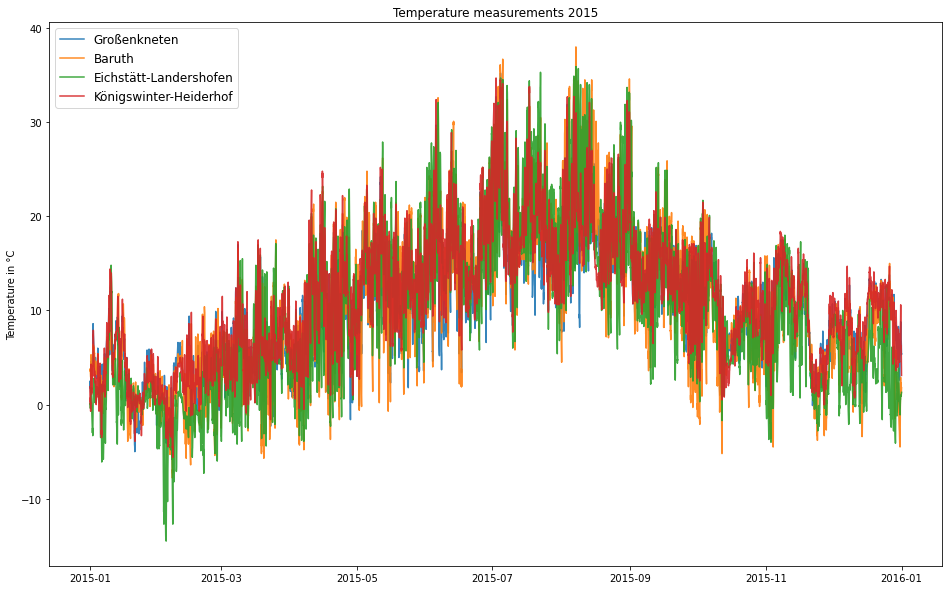

In [79]:
plt.figure(figsize=(16,10))
plt.plot(temperature_y1.index, temperature_y1, alpha = .9,)
plt.title("Temperature measurements 2015")
plt.ylabel('Temperature in °C')
plt.legend(['Großenkneten', 'Baruth', 'Eichstätt-Landershofen', 'Königswinter-Heiderhof'], loc = 2, fontsize = 'large')
plt.show()

In [80]:
power = power.rename(columns = {'DateUTC': 'date', 'Value': 'value'})
power = power.set_index('date')

I changed the data type, because when I tried to plot the data, I got an error that my computer does not have enough memory

In [81]:
power = power['value'].astype('int32')

In [82]:
power = power.to_frame()

In [83]:
power

,value
date,
2015-01-01 00:00:00,45814
2015-01-01 01:00:00,44189
2015-01-01 02:00:00,42773
2015-01-01 03:00:00,42173
2015-01-01 04:00:00,41472
...,...
2018-12-31 19:00:00,51404
2018-12-31 20:00:00,49750
2018-12-31 21:00:00,49220


In [84]:
power.describe()

,value
count,35064.000000
mean,58975.396446
std,10362.835805
min,35800.000000
25%,50208.000000
50%,58657.000000
75%,67982.000000
max,81109.000000


In [85]:
power_y1 = power[power.index < '2016']

It looks like the days of the week have the biggest impact, but there is also seasonal variance.

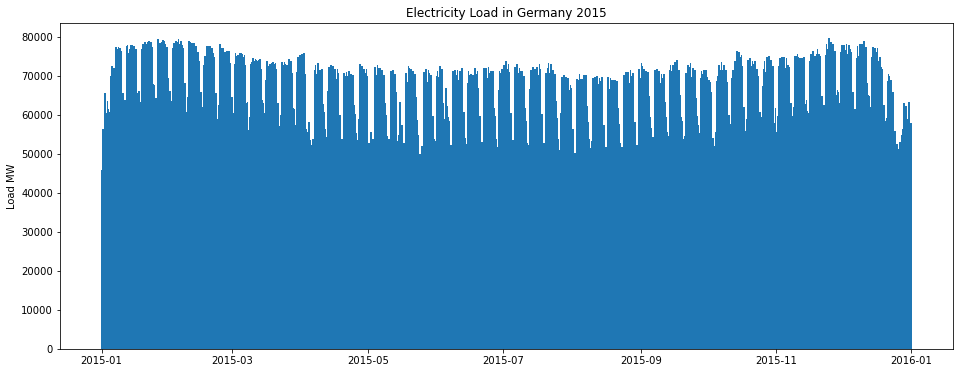

In [86]:
plt.figure(figsize=(16,6))
plt.bar(power_y1.index, power_y1.value)
plt.title("Electricity Load in Germany 2015")
plt.ylabel('Load MW')
plt.show()

It looks like the days of the week have the biggest impact, but there is also seasonal variance.

In [87]:
power = power/1000

I change the measurement from MW to GW, so that the values are more comparable to the °C.

### 5. Performing linear regression

In [89]:
features_train, features_test, target_train, target_test = train_test_split(
    temperature, power.value, train_size = 0.7, test_size = 0.3, random_state = 42)
print(features_train.shape, features_test.shape, target_train.shape, target_test.shape, sep = "\r\n")

(24544, 4)
(10520, 4)
(24544,)
(10520,)


In [90]:
target_test

date
2015-09-10 22:00:00    49.251
2018-09-20 08:00:00    69.467
2016-01-04 14:00:00    68.312
2015-03-03 19:00:00    70.502
2015-06-25 19:00:00    59.155
                        ...  
2015-10-26 01:00:00    44.155
2015-01-09 10:00:00    77.102
2017-12-23 22:00:00    48.874
2016-09-27 12:00:00    67.425
2015-10-16 07:00:00    73.539
Name: value, Length: 10520, dtype: float64

In [91]:
reg = LinearRegression()
reg.fit(features_train, target_train)

LinearRegression()

The coefficient are small. One explanation could be that in Germany natural gas is used more for heating than electricity and the seasonal variance is more due to different amount of sunlight.   

In [92]:
print(reg.coef_, reg.intercept_)

[ 0.04837512  0.14405931  0.14059567 -0.5099519 ] 61.33936901255663


I can’t explain why the first and last coefficient are so different, since the temperature from these two stations had the highest correlation.

In [93]:
features_pred = reg.predict(features_test)

In [94]:
r2_score(target_test, features_pred)

0.02299990617365988

### 6. Conclusion
Temperature does not explain the variance in electricity consumption in Germany.